In [39]:
from pathlib import Path
import tflite
import tvm
from tvm import relay, transform
from tvm import te
import matplotlib.pyplot as plt
import imageio
import cv2
import numpy as np
from typing import NamedTuple

from matplotlib.patches import Rectangle

In [4]:
tvm.__version__

'0.8.dev0'

In [2]:
model_path = Path.cwd().parent / 'models' / 'face_detection_short_range.tflite'
model_path.exists()

True

In [3]:
with open(model_path, 'rb') as f:
    tflite_model_buf = f.read()
    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
    input_tensor = "input"
    input_shape  = (1, 128, 128, 3)
    input_dtype  = "float32"
    
    mod, params = relay.frontend.from_tflite(
        tflite_model, 
        shape_dict = {input_tensor: input_shape},
        dtype_dict = {input_tensor: input_dtype}
    )
    target = "llvm"
    with transform.PassContext(opt_level=3):
        lib=relay.build(mod, target, params=params)

conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with a

In [5]:
video_path = Path.cwd().parent / "build" / "demo1.mp4"
video_path.exists()

True

In [6]:
reader = imageio.get_reader(str(video_path))

In [7]:
image_data = None
for frame in reader:
    image_data = cv2.resize(frame, (128, 128))
    image_data = image_data * 1.0 / 255.0
    image_data = image_data.astype(np.float32)
    break
image_data.shape, image_data.dtype

((128, 128, 3), dtype('float32'))

In [49]:
frame.shape

(432, 768, 3)

In [8]:
image_data = image_data[np.newaxis, :]
image_data.shape

(1, 128, 128, 3)

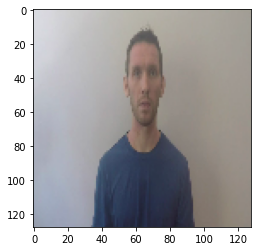

In [9]:
plt.imshow(np.squeeze(image_data))
plt.show()

In [10]:
import tvm
from tvm import te
from tvm.contrib import graph_executor as runtime

# Create a runtime executor module
module = runtime.GraphModule(lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()

In [11]:
output_1 = module.get_output(0).numpy()
output_2 = module.get_output(1).numpy()

In [12]:
output_1.shape

(1, 896, 16)

In [13]:
output_2.shape

(1, 896, 1)

In [17]:
scores = np.squeeze(output_2)

RAW_SCORE_LIMIT = 80
scores[scores < -RAW_SCORE_LIMIT] = -RAW_SCORE_LIMIT
scores[scores > RAW_SCORE_LIMIT] = RAW_SCORE_LIMIT
    
scores = 1 / (1 + np.exp(-scores))
max_score_index = np.argmax(scores)
max_score = scores[max_score_index]
max_score, max_score_index

(0.82998896, 177)

In [26]:
SSD_OPTIONS_FRONT = {
    'num_layers': 4,
    'input_size_height': 128,
    'input_size_width': 128,
    'anchor_offset_x': 0.5,
    'anchor_offset_y': 0.5,
    'strides': [8, 16, 16, 16],
}

def get_anchor_boxes(opts: dict):
    layer_id = 0
    num_layers = opts['num_layers']
    strides = opts['strides']
    assert len(strides) == num_layers
    input_height = opts['input_size_height']
    input_width = opts['input_size_width']
    anchor_offset_x = opts['anchor_offset_x']
    anchor_offset_y = opts['anchor_offset_y']
    anchors = []
    while layer_id < num_layers:
        last_same_stride_layer = layer_id
        repeats = 0
        while (last_same_stride_layer < num_layers and
               strides[last_same_stride_layer] == strides[layer_id]):
            last_same_stride_layer += 1
            repeats += 2    # aspect_ratios are added twice per iteration
        stride = strides[layer_id]
        feature_map_height = input_height // stride
        feature_map_width = input_width // stride
        for y in range(feature_map_height):
            y_center = (y + anchor_offset_y) / feature_map_height
            for x in range(feature_map_width):
                x_center = (x + anchor_offset_x) / feature_map_width
                for _ in range(repeats):
                    anchors.append((x_center, y_center))
        layer_id = last_same_stride_layer
    return np.array(anchors, dtype=np.float32)


In [31]:
def decode_boxes(raw_boxes: np.ndarray, anchors) -> np.ndarray:
    """Simplified version of
    mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
    """
    scale = 128
    num_points = raw_boxes.shape[-1] // 2
    
    # scale all values (applies to positions, width, and height alike)
    boxes = raw_boxes.reshape(-1, num_points, 2) / scale
    # adjust center coordinates and key points to anchor positions
    boxes[:, 0] += anchors
    
    for i in range(2, num_points):
        boxes[:, i] += anchors
    # convert x_center, y_center, w, h to xmin, ymin, xmax, ymax
    center = np.array(boxes[:, 0])
    half_size = boxes[:, 1] / 2
    boxes[:, 0] = center - half_size
    boxes[:, 1] = center + half_size
    return boxes

In [62]:
anchors = get_anchor_boxes(SSD_OPTIONS_FRONT)
raw_boxes = np.squeeze(output_1)
boxes = decode_boxes(raw_boxes, anchors)
boxes.shape

(896, 8, 2)

In [81]:
MIN_SCORE = 0.5
score_above_threshold = scores > MIN_SCORE
idx = np.argwhere(score_above_threshold)
filtered_scores = scores[score_above_threshold]
filtered_boxes =  boxes[idx[:, 0], :]
filtered_boxes.dtype

dtype('float32')

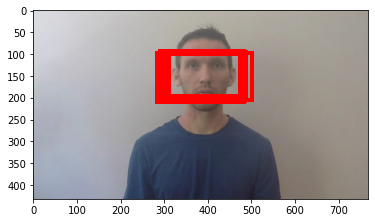

In [76]:
plt.imshow(frame)
for bb in filtered_boxes:
    x1 = int(bb[0][0] * frame.shape[1])
    y1 = int(bb[0][1] * frame.shape[0])

    x2 = int(bb[1][0] * frame.shape[1])
    y2 = int(bb[1][1] * frame.shape[0])

    w = int(abs(x1 - x2))
    h = int(abs(y1 - y2))
    plt.gca().add_patch(Rectangle((x1,y1), w, h,
                        edgecolor='red',
                        facecolor='none',
                        lw=4))
plt.show()